<a href="https://colab.research.google.com/github/J-HKim/1D_ED/blob/main/1D_ED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymatgen
from google.colab import drive
drive.mount('/content/gdrive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.3/515.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.3/154.3 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 19.7 MB/s eta 0:00:00
Mounted at /content/gdrive


In [2]:
import os
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
from pymatgen.io.cif import CifParser
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from google.colab import files

def read_data(file_content):
    data = [line.strip().split() for line in file_content.decode().split("\n") if line]
    data = [[float(x) for x in row] for row in data]
    return data

def process_xrd_data():     #  The window_length must always be an odd number and the polyorder must be less than or equal to the window_length.(The higher you set both parameters, the more noise and background is removed.)
    def preprocess_data(peak_data, use_smoothing='yes', prominence=0, window_length=7, polyorder=5, k_alpha_ratio=0.5):
        background_removal = peak_data.copy()
        if use_smoothing.lower() == 'yes':
            background_removal[:, 1] = savgol_filter(peak_data[:, 1], window_length, polyorder)
        peak_data[:, 1] -= background_removal[:, 1]
        max_int = np.max(peak_data[:, 1])
        peaks, _ = find_peaks(peak_data[:, 1], prominence=prominence)
        for peak in peaks:
            if peak_data[peak, 1] * k_alpha_ratio > peak_data[peak + 1, 1]:
                peak_data[peak + 1, 1] = 0
            else:
                peak_data[peak, 1] -= peak_data[peak + 1, 1] * k_alpha_ratio
        processed_peaks = peak_data[peaks]
        processed_peaks[:, 1] /= max_int
        processed_peaks[:, 1] *= 100
        return processed_peaks


    def pair_peaks(experimental_peaks, simulated_x, simulated_y, hkls, theta_diff_limit, intensity_percentage_limit):
        matched_peaks = []
        sim_peak_data = [(x, y, idx, tuple(hkl_data[0]['hkl'])) for idx, (x, y, hkl_data) in enumerate(zip(simulated_x, simulated_y, hkls)) if hkl_data]

        for s_data in sim_peak_data:
            s_x, s_y, s_idx, s_hkl = s_data
            peak_candidates = []

            for e_peak in experimental_peaks:
                theta_diff = abs(s_x - e_peak[0])

                # Check 2θ difference condition
                if theta_diff <= theta_diff_limit:
                    # Check intensity percentage condition
                    #if (s_y - s_y * intensity_percentage_limit / 100) <= e_peak[1] <= (s_y + s_y * intensity_percentage_limit / 100):
                        intensity_diff = abs(s_y - e_peak[1])
                        peak_candidates.append((intensity_diff, e_peak))

            # If there are any peak candidates, choose one with the smallest intensity difference
            if peak_candidates:
                peak_candidates.sort(key=lambda x: x[0])  # Sort by intensity difference
                matched_e_peak = peak_candidates[0][1]  # Choose the peak with the smallest intensity difference

                # Add the matched peak to the matched_peaks list
                matched_peaks.append((s_hkl, s_x, s_y, matched_e_peak[0], matched_e_peak[1]))

        # Convert matched peaks to dataframe
        df = pd.DataFrame(matched_peaks, columns=["hkl", "Sim. 2θ(°)", "Sim. Intensity", "Exp. 2θ(°)", "Exp. Intensity"])
        # Save dataframe to Excel
        df.to_excel("/content/gdrive/MyDrive/XRD.xlsx", index=False)

        return matched_peaks

    uploaded = files.upload()
    peak_file_name = list(uploaded.keys())[0]
    peak_data = np.array(read_data(uploaded[peak_file_name]))
    processed_peaks = preprocess_data(peak_data, prominence=0)

    cod_id = "8103820"
    url = f"http://www.crystallography.net/cod/{cod_id}.cif"
    response = requests.get(url)
    parser = CifParser.from_string(response.text)
    structure = parser.get_structures(primitive=False)[0]
    calculator = XRDCalculator()
    pattern = calculator.get_pattern(structure)

    matched_peaks = pair_peaks(processed_peaks, pattern.x, pattern.y, pattern.hkls, theta_diff_limit=0.5, intensity_percentage_limit=200)

    return matched_peaks

if __name__ == "__main__":
    matched_peaks = process_xrd_data()

    for peak in matched_peaks:
        print(f"hkl: {peak[0]}, Sim 2theta: {peak[1]}, Sim intensity: {peak[2]}, Exp 2theta: {peak[3]}, Exp intensity: {peak[4]}")

Saving 201029-1.x_y to 201029-1.x_y


<ipython-input-2-f3df304a1d4e>:76: DeprecationWarning: `from_string` is deprecated!
Use from_str instead
  parser = CifParser.from_string(response.text)
/usr/local/lib/python3.10/dist-packages/pymatgen/io/cif.py:1145: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


hkl: (1, 0, -1, 0), Sim 2theta: 10.354410254804929, Sim intensity: 1.4595781820971372, Exp 2theta: 10.271808493, Exp intensity: 1.0161758606388251
hkl: (1, 0, -1, 1), Sim 2theta: 15.806533846884854, Sim intensity: 0.14793587783921974, Exp 2theta: 16.259217394, Exp intensity: 1.3272501036913849
hkl: (2, -1, -1, 0), Sim 2theta: 17.983699789766984, Sim intensity: 7.346212998642011, Exp 2theta: 17.637897075, Exp intensity: 7.382828701783368
hkl: (2, 0, -2, 0), Sim 2theta: 20.79459234836904, Sim intensity: 37.412172143085066, Exp 2theta: 20.474038133, Exp intensity: 32.84944006636171
hkl: (2, -1, -1, 1), Sim 2theta: 21.624882103920623, Sim intensity: 41.60344151168149, Exp 2theta: 21.826457248, Exp intensity: 38.53172957278977
hkl: (0, 0, 0, 2), Sim 2theta: 23.951622152128277, Sim intensity: 9.158829384155162, Exp 2theta: 24.38686237, Exp intensity: 9.20779759435904
hkl: (2, 0, -2, 1), Sim 2theta: 24.030145995987837, Sim intensity: 0.5394080823882675, Exp 2theta: 24.334341239, Exp intensity

Type 1 Matched Peaks:
Sim type (hkl: (0, 0, 0, 2), 2theta: 23.95, intensity: 9.16), Exp type (hkl: (0, 0, 0, 2), 2theta: 24.39, intensity: 9.21)
Sim type (hkl: (0, 0, 0, 4), 2theta: 49.04, intensity: 14.11), Exp type (hkl: (0, 0, 0, 4), 2theta: 48.70, intensity: 14.27)
Sim type (hkl: (0, 0, 0, 6), 2theta: 77.00, intensity: 0.54), Exp type (hkl: (0, 0, 0, 6), 2theta: 76.99, intensity: 0.44)

Type 2 Matched Peaks:
Sim type (hkl: (1, 0, -1, 0), 2theta: 10.35, intensity: 1.46), Exp type (hkl: (1, 0, -1, 0), 2theta: 10.27, intensity: 1.02)
Sim type (hkl: (2, 0, -2, 0), 2theta: 20.79, intensity: 37.41), Exp type (hkl: (2, 0, -2, 0), 2theta: 20.47, intensity: 32.85)
Sim type (hkl: (3, 0, -3, 0), 2theta: 31.41, intensity: 47.13), Exp type (hkl: (3, 0, -3, 0), 2theta: 31.52, intensity: 38.91)
Sim type (hkl: (4, 0, -4, 0), 2theta: 42.32, intensity: 6.24), Exp type (hkl: (4, 0, -4, 0), 2theta: 42.73, intensity: 5.97)
Sim type (hkl: (5, 0, -5, 0), 2theta: 53.64, intensity: 0.06), Exp type (hkl: (5

<ipython-input-3-29335547ee63>:107: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


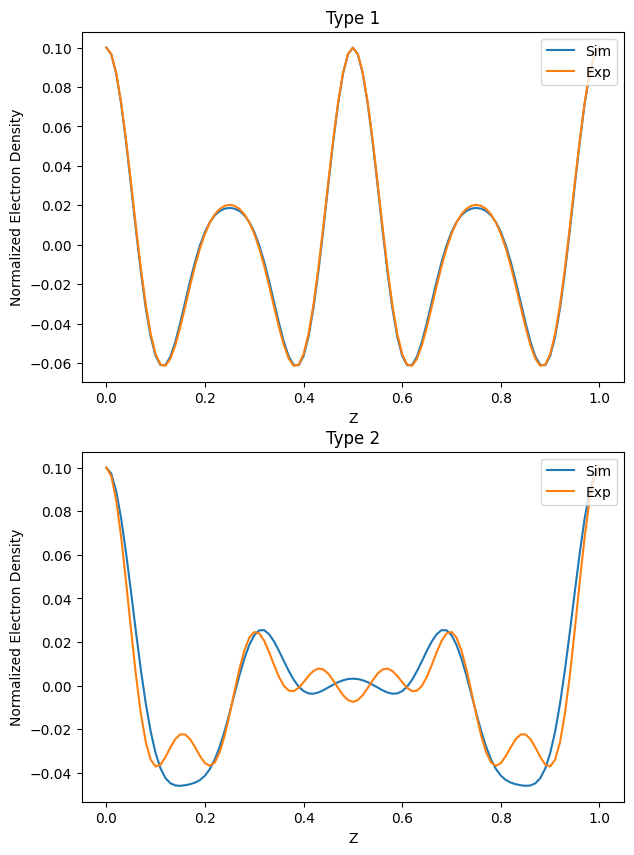

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def parse_hkl(hkl):
    if isinstance(hkl, str):
        hkl = eval(hkl)

    if len(hkl) == 3:
        return hkl
    elif len(hkl) == 4:
        return hkl[0], hkl[1], hkl[3]

def calculate_lp(two_theta):
    rad = np.deg2rad(two_theta)
    return (1 + np.cos(rad)**2) / (np.sin(rad/2)**2 * np.cos(rad/2))

def calculate_electron_density(data, peak_type, sim_or_exp, C):
    Z = np.arange(0, 1.01, 0.01)
    electron_density = np.zeros(Z.shape)

    for index, row in data.iterrows():
        hkl = row["hkl"]
        h, k, l = parse_hkl(hkl)
        if sim_or_exp == 'Sim':
            two_theta = row['Sim. 2θ(°)']
            intensity = row['Sim. Intensity']
        elif sim_or_exp == 'Exp':
            two_theta = row['Exp. 2θ(°)']
            intensity = row['Exp. Intensity']

        L = l if peak_type == 1 else h

        lp = calculate_lp(two_theta)

        # if intensity is less than 0, set it to 0
        if intensity < 0:
            intensity = 0

        F = np.sqrt(intensity / lp)
        electron_density += F * np.cos(2 * np.pi * L * Z)

    normalized_density = electron_density / C / np.max(electron_density)
    return Z, normalized_density

# Read data
data_path = "/content/gdrive/MyDrive/XRD.xlsx"
data = pd.read_excel(data_path)

# Filter peaks
def filter_peaks(data, peak_type):
    filtered_peaks = []

    for index, row in data.iterrows():
        hkl = row["hkl"]
        h, k, l = parse_hkl(hkl)

        if peak_type == 1 and (h, k, l) == (0, 0, l):
            filtered_peaks.append(row)
        elif peak_type == 2 and (h, k, l) == (h, 0, 0):
            filtered_peaks.append(row)

    return pd.DataFrame(filtered_peaks)

filtered_peaks_1 = filter_peaks(data, peak_type=1)
filtered_peaks_2 = filter_peaks(data, peak_type=2)

def print_filtered_peaks(filtered_peaks, peak_type):
    print(f"Type {peak_type} Matched Peaks:")
    for _, row in filtered_peaks.iterrows():
        hkl = row["hkl"]
        sim_2theta = row["Sim. 2θ(°)"]
        sim_intensity = row["Sim. Intensity"]
        exp_2theta = row["Exp. 2θ(°)"]
        exp_intensity = row["Exp. Intensity"]
        sim_type = f"Sim type (hkl: {hkl}, 2theta: {sim_2theta:.2f}, intensity: {sim_intensity:.2f})"
        exp_type = f"Exp type (hkl: {hkl}, 2theta: {exp_2theta:.2f}, intensity: {exp_intensity:.2f})"
        print(f"{sim_type}, {exp_type}")
    print()

print_filtered_peaks(filtered_peaks_1, peak_type=1)
print_filtered_peaks(filtered_peaks_2, peak_type=2)

# Calculate electron density
C = 10
Z_Sim1, norm_dens_Sim1 = calculate_electron_density(filtered_peaks_1, peak_type=1, sim_or_exp='Sim', C=C)
Z_Exp1, norm_dens_Exp1 = calculate_electron_density(filtered_peaks_1, peak_type=1, sim_or_exp='Exp', C=C)
Z_Sim2, norm_dens_Sim2 = calculate_electron_density(filtered_peaks_2, peak_type=2, sim_or_exp='Sim', C=C)
Z_Exp2, norm_dens_Exp2 = calculate_electron_density(filtered_peaks_2, peak_type=2, sim_or_exp='Exp', C=C)

# Convert data to DataFrame
df_Sim1 = pd.DataFrame({'Z': Z_Sim1, 'Normalized Electron Density': norm_dens_Sim1})
df_Exp1 = pd.DataFrame({'Z': Z_Exp1, 'Normalized Electron Density': norm_dens_Exp1})
df_Sim2 = pd.DataFrame({'Z': Z_Sim2, 'Normalized Electron Density': norm_dens_Sim2})
df_Exp2 = pd.DataFrame({'Z': Z_Exp2, 'Normalized Electron Density': norm_dens_Exp2})

# Create a Pandas Excel writer using openpyxl as the engine.
writer = pd.ExcelWriter("/content/gdrive/MyDrive/ED.xlsx", engine='openpyxl')

# Write each DataFrame to a different worksheet.
df_Sim1.to_excel(writer, sheet_name='Sim (0,0,0,l)', index=False)
df_Exp1.to_excel(writer, sheet_name='Exp (0,0,0,l)', index=False)
df_Sim2.to_excel(writer, sheet_name='Sim (h,0,-h,0)', index=False)
df_Exp2.to_excel(writer, sheet_name='Exp (h,0,-h,0)', index=False)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

# Plot results in separate subplots
fig, ax = plt.subplots(2, figsize=(7, 10))

ax[0].plot(Z_Sim1, norm_dens_Sim1, label='Sim')
ax[0].plot(Z_Exp1, norm_dens_Exp1, label='Exp')
ax[0].set_title("Type 1")
ax[0].set_xlabel("Z")
ax[0].set_ylabel("Normalized Electron Density")
ax[0].legend(loc='upper right')

ax[1].plot(Z_Sim2, norm_dens_Sim2, label='Sim')
ax[1].plot(Z_Exp2, norm_dens_Exp2, label='Exp')
ax[1].set_title("Type 2")
ax[1].set_xlabel("Z")
ax[1].set_ylabel("Normalized Electron Density")
ax[1].legend(loc='upper right')

plt.show()